# Machine learning

Ce programme est une initiation à la conception d'un projet de **machine learning**.

Les jeux de données iris.data & wdbc.data sont utilisés.

## Les import

In [1]:
%%capture

from collections import Counter
import pandas as pd
import numpy as np
import sys

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf

# Modules
from __modules__.data_file import read_data
from __modules__.visualisation import *
from __modules__.summarize import *
from __modules__.acp import *

# Iris dataset

In [2]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris = read_data("iris.data", col_names, float)

## Charger les données

> Input variables X

In [3]:
X = iris.iloc[:,0:4].to_numpy()
X.shape

(150, 4)

> Variables de sortie Y de type matrice BINAIRE

In [4]:
Y = iris['class'].to_numpy()
iteration_item = Counter(Y)
iteration_item

Counter({'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50})

Les classes sont **équilibrées** - 50 individus chacune

In [5]:
for i, key in enumerate(iteration_item.keys()):
    Y[Y == key] = i
Y.shape

(150,)

> Scale des données tel que moyenne=0 & ecart_type=1

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

> Set d'apprentissage et de test


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=2)

Ici 3 classes avec 50 individus chacune. Donc faire une matrice binaire telle que:

- Les 50 1er individus - 1 0 0
- Les 50 suivants - 0 1 0
- Les 50 derniers - 0 0 1

**=> one hot encoding**

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Visualisation des données

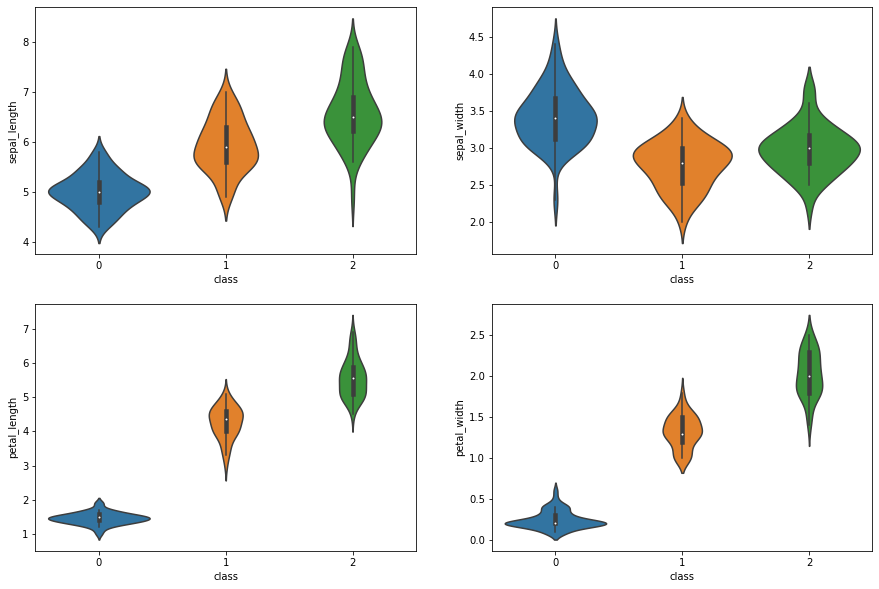

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


<Figure size 432x288 with 0 Axes>

In [9]:
violin_plot_iris(iris)
%time

## KERAS MODEL

La classe **Dense** permet de faire des strucuture de neurones complétement connectées

- La 1ère couche chachée est composée de 10 noeuds et utilise la fonction d'activation relu
- La 2ème couche chachée est composée de 5 noeuds et utilise la fonction d'activation relu
- La couche de sortie est composée de 3 noeuds (3 classes) et utilise la fonction d'activation softmax

### Définition du modèle Keras

In [10]:
model = Sequential()
model.add(Dense(10, input_dim=4, activation=tf.nn.relu))
model.add(Dropout(0.3))

model.add(Dense(5, activation=tf.nn.relu))
model.add(Dropout(0.2))

model.add(Dense(3, activation=tf.nn.softmax, name="output"))

### Compilation du modèle Keras

Modèle *training*
> Trouve le meilleur set de poids pour faire correspondre les entrées avec les sorties

Propriété à renseigner pour la compilation du modèle

  - Loss: indique la fonction utilisée pour évaluer un set de poids, i.e: l'écart entre ce qui est produit par le réseau et ce qui est attendu (écart au moindre carré, crossentropy, ...)
  - Optimizer
  
  

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
output (Dense)               (None, 3)                 18        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


### Fit le modèle Keras

La fonction **fit()** permet d'entrainer et de fit notre modèle sur nos data.

**L'entrainement se fait à travers un certain nombre d'itération (epoch) et chaque epoch est divisé en batches**

  - **Epoch**: le nombre d'itérations faites sur le dataset pour l'entrainement
  - **Batch**: le nombre d'éléments d'une epoch considérés avant qu'un gradient soit calculé et que les poids soient mis à jour
  
=> Une **epoch** est constituée d'un ou plusieurs **batches**

> Batch élevé: nombre de gradient calculé faible mais ils seront d'autant plus précis
> Batch faible: nombre de gradient calculé élevé mais ils seront peu précis

In [12]:
history = model.fit(x=x_train, y=y_train, epochs=200, batch_size=15, 
                    validation_data=(x_test, y_test), validation_split=0.2, verbose=0)

## Evaluating the Model

In [13]:
loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: {:3f} & Loss: {:3f}".format(acc, loss))

75/75 [==============================] - 0s 77us/step
Accuracy: 0.946667 & Loss: 0.242522


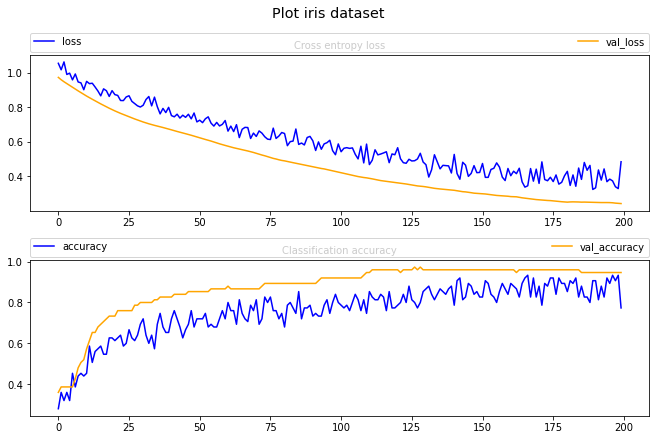

<Figure size 432x288 with 0 Axes>

In [14]:
summarize_model(history.history, "Plot iris dataset")

L'accuracy en apprentissage et test est bonne (90%). Au vu du graphique, le modèle présente donc de bonne performance en **généralisation** (test) et en **resubstitution** (apprentissage). 

De plus, il ne semble pas y avoir de sur/sous-apprentissage.

## Prédiction

In [15]:
predict = model.predict_classes(x_test)
confusion = pd.DataFrame(confusion_matrix(predict, np.argmax(y_test, axis=1)), 
                         columns=['Setosa', 'Versicolore', 'Virginica'], 
                         index=['Setosa', 'Versicolore', 'Virginica'])
confusion.columns = pd.MultiIndex.from_product([['Observées'], confusion.columns])
confusion.index = pd.MultiIndex.from_product([['Prédites'], confusion.index])
confusion

Observées                      
                        Setosa Versicolore Virginica
Prédites Setosa             27           0         0
         Versicolore         0          22         3
         Virginica           0           1        22

## Cross validation

In [16]:
def define_model():
    # Define model
    model = Sequential()
    model.add(Dense(10, input_dim=4, activation=tf.nn.relu))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation=tf.nn.softmax, name="output"))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
estimator = KerasClassifier(build_fn=define_model, epochs=200, batch_size=15, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(estimator, X_scaled, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

Baseline: 93.33% (9.43%)


# Breast-cancer-wisconsin dataset

En général, penser a vérifier plusieurs choses sur le jeu de données : 

- Vérifier que les données soient bien numériques applymap(np.isreal).all()
- Observer les données sous forme de summary (sous R) ou de .describe() (sous Python)
- Vérfier les effectifs de chaque classes et faire un group by -> si les classes ne sont pas équilibrées, changer les poids des classes (oversampling, undersampling, class based weight, instrance based weight) 
- Vérfier constamment le shape pour être certain de ne pas avoir de pb dans les data (surtout en cas de conversion)

Pour les données WISCONSIN :

- Afficher des violin plots pour chaque descripteur et pour tous les descripteurs en même temps (ou faire un describe())
- Les données doivent être normalisées (normalisation par z_score OU z_score robuste si vous êtes un peu "manique")
- Faire une ACP


## Load data

In [18]:
wdbc = read_data("wdbc.data")
wdbc.shape

(569, 32)

In [19]:
wdbc.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,569,569,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,569
unique,569,2,456,479,522,539,474,537,537,542,...,457,511,514,544,411,529,539,492,500,535
top,8712853,B,12.34,15.7,134.7,512.2,0.1007,0.1147,0,0,...,12.36,27.26,101.7,472.4,0.1216,0.3416,0,0,0.2972,0.07427
freq,1,357,4,3,3,3,5,3,13,13,...,5,3,3,2,4,3,13,13,3,3


- 1 variable qualitative - diagnostic (maladie maligne ou bénigne)
- 31 variables quantitatives - la colonne 0 correspond à l'id des protéines 

## Visualisation

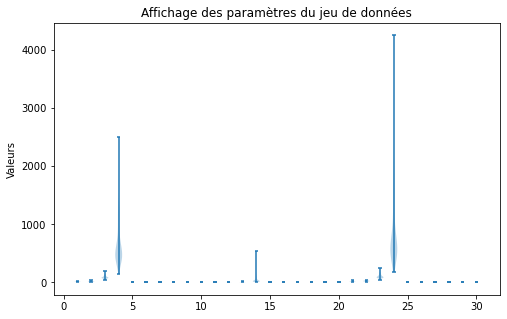

In [20]:
violin_plot_wdbc_global(wdbc)

On observe une dispartité importante entre les données, une étape de normalisation sera donc appliquée.

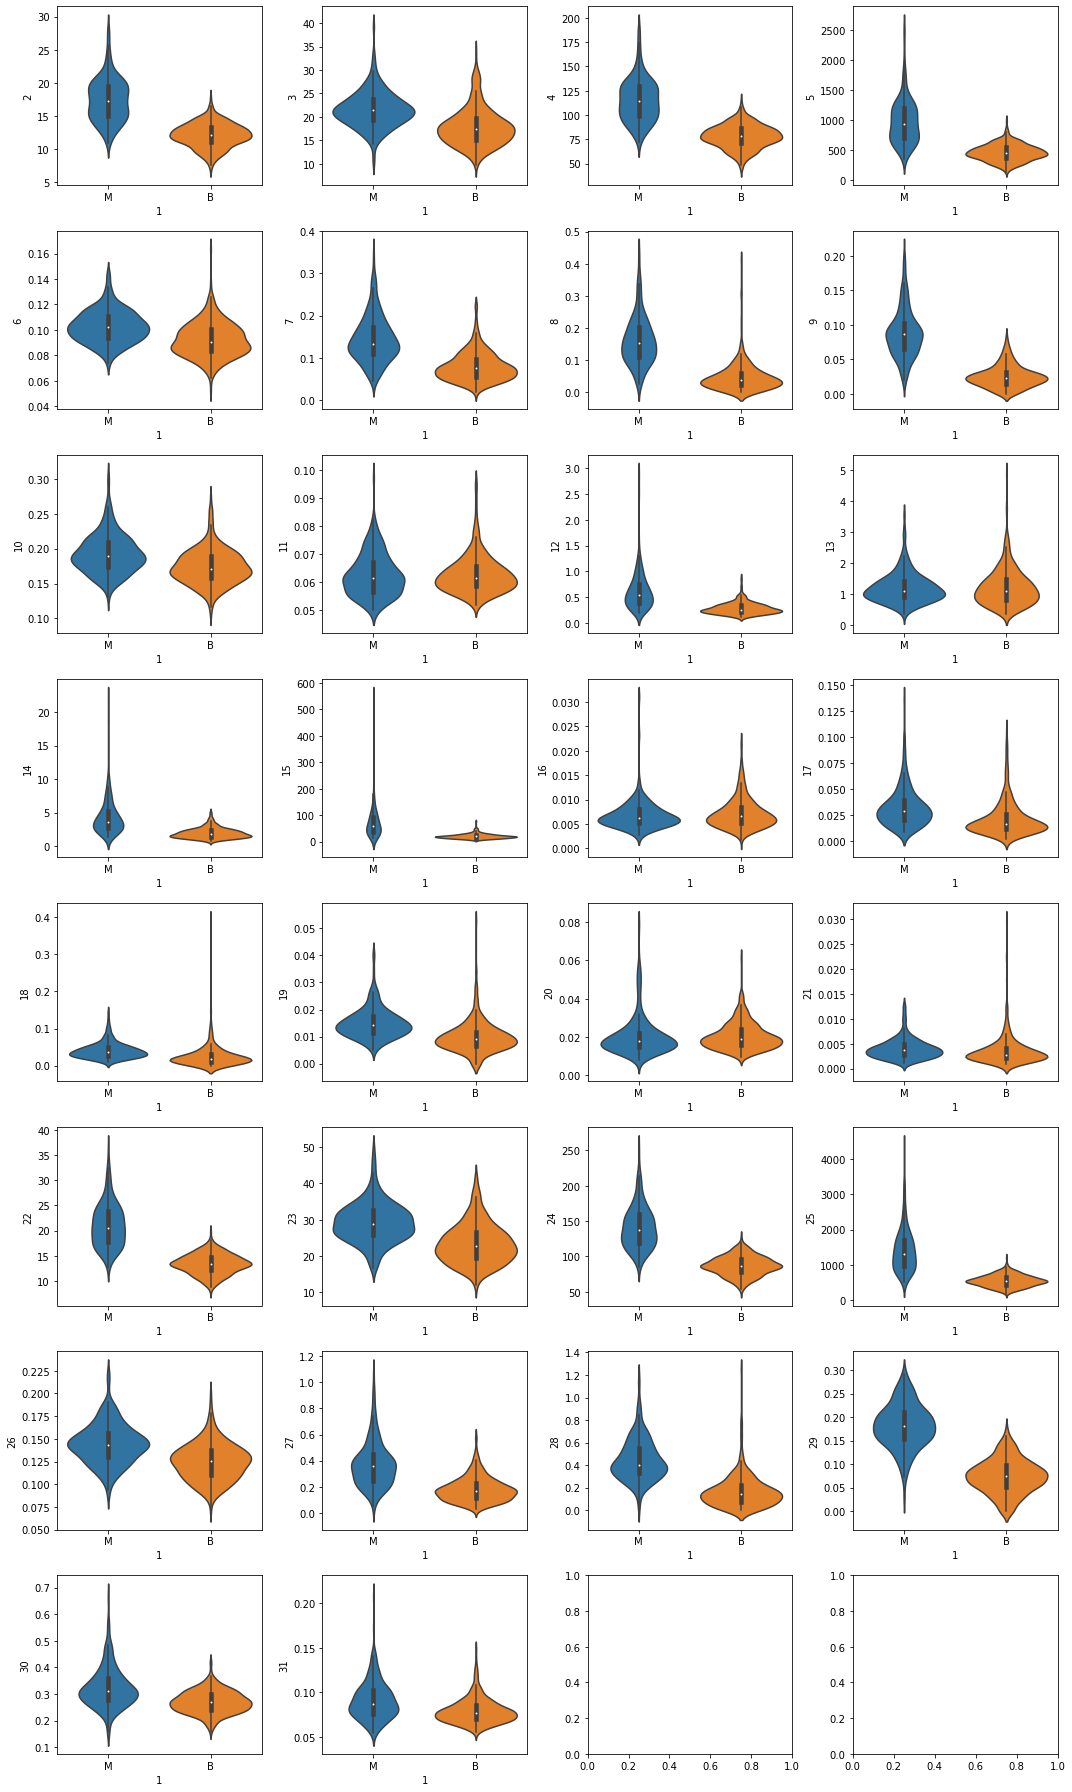

In [21]:
violin_plot_wdbc_specific(wdbc)

## Traitement des données

> Valeur d'entrer

In [22]:
X = wdbc.iloc[:,2:].to_numpy()
X.astype('float32')
X.shape

(569, 30)

Normalisation des données nécessaire

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(569, 30)

> *Valeur de sortie - one hot encoding*

In [24]:
Y = wdbc.iloc[:,1].to_numpy()
Y.shape

(569,)

In [25]:
iteration_item = Counter(Y)  # détermine le nombre d'itération de chaque ele de wdbc[:,1] -> méthode
print(iteration_item)

Counter({'B': 357, 'M': 212})


Désiquilibre important dans le nombre d'individus des classes B (bénigne) et M (maligne)

Rééquilibrage nécessaire

- Oversampling: sélectionner aléatoirement x observations de la classe sous représentée M et les ajouter à M pour obtenir le même nombre d'individus
- Undersampling: retirer x observations de B pour obtenir le même nombre d'individus
- Pondérer les observations (better)
    > nb(B) / nb(M) -> poids de M 
      
    > nb(M) / nb(B) -> poids de B
- Data augmentation: créer des données proche de celle existente (M) pour obtenir le même nombre d'individus

In [26]:
for i, key in enumerate(sorted(iteration_item.keys())):
    Y[Y == key] = i
Y.shape, Counter(Y)  # 0: B & 1: M

((569,), Counter({1: 212, 0: 357}))

> Set d'apprentissage et de test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

print("x_train dataset {}".format(x_train.shape))
print("y_train dataset {}".format(y_train.shape), end="\n\n")
print("x_test dataset {}".format(x_test.shape))
print("y_test dataset {}".format(y_test.shape), end="\n\n")

x_train dataset (398, 30)
y_train dataset (398,)

x_test dataset (171, 30)
y_test dataset (171,)



> Désiquilibres des classes donc un traitement préalable est nécessaire, ici il a été choisi de pondérer les obseravations 

In [28]:
%%capture
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [29]:
class_weights

array([0.78656126, 1.37241379])

> *to_categorical* permet de créer la matrice binaire des variables output - one hot encoding

In [30]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(398, 2)
(171, 2)


## ACP

> Modèle ACP

In [31]:
pca = PCA(n_components=3)  # On paramètre ici pour ne garder que 3 composantes
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)
print(pca.components_)

[0.44272026 0.18971182 0.09393163]
[86.93235745 56.90677266 40.04263937]
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825723  0.14188335  0.27533947]
 [-0.00853124  0.06454992 -0.00931422  0.02869952 -0.1042919  -0.07409159
   0.00273385 -0.02556352 -0.04023993 -0.02257413  0.2684814   0.37463366
   0.26664537  0.21600653  0.30883898 

> Résultat ACP

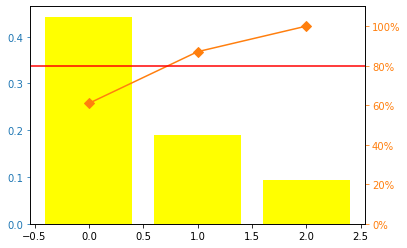

Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Le mode density actif n'apparait que si BigData est paramétré.


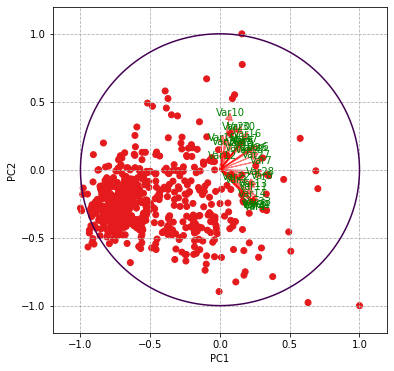

In [32]:
data_sortie= pca.fit_transform(X_scaled)
pareto(pca.explained_variance_ratio_)
biplot(score=data_sortie[:,0:2], coeff=np.transpose(pca.components_[0:2, :]))

## Modèle keras

In [33]:
def define_model():
    # Définition
    model = Sequential()
    model.add(Dense(10, input_dim=30, activation=tf.nn.relu))
    model.add(Dropout(0.3))

    model.add(Dense(2, activation=tf.nn.softmax, name="output"))
    
    # Compilation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

> Output layer -> 2 car 2 classes

In [34]:
model = define_model()
model.summary()
history = model.fit(x=x_train, y=y_train, epochs=200, batch_size=30, 
                    validation_data=(x_test, y_test), 
                    class_weight=class_weights, verbose=0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                310       
_________________________________________________________________
dropout_23 (Dropout)         (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________


## Evaluating the model

In [35]:
loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: {:4f} & Loss: {:4f}".format(acc, loss))

171/171 [==============================] - 0s 60us/step
Accuracy: 0.906433 & Loss: 0.282681


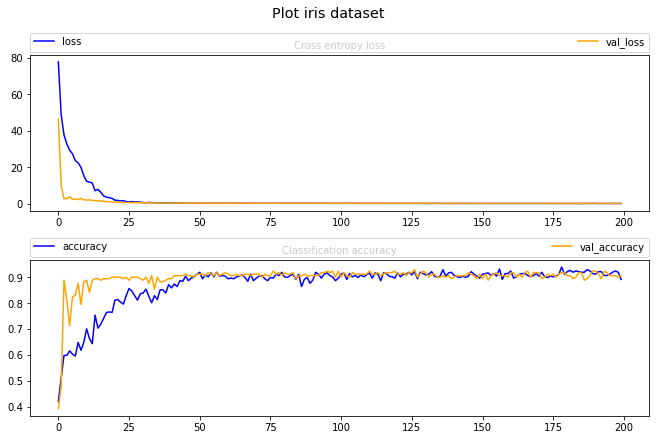

<Figure size 432x288 with 0 Axes>

In [36]:
summarize_model(history.history, "Plot iris dataset")

## Prédiction

In [37]:
predict = model.predict_classes(x_test)
confusion_matrix(predict, np.argmax(y_test, axis=1))
confusion = pd.DataFrame(confusion_matrix(predict, np.argmax(y_test, axis=1)), 
                         columns=['B', 'M'], index=['B', 'M'])
confusion.columns = pd.MultiIndex.from_product([['Observées'], confusion.columns])
confusion.index = pd.MultiIndex.from_product([['Prédites'], confusion.index])
confusion

Observées    
                   B   M
Prédites B        97   9
         M         7  58

## Cross validation

In [40]:
estimator = KerasClassifier(build_fn=define_model, epochs=200, batch_size=15, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(estimator, X_scaled, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

Baseline: 98.07% (2.14%)
